# scVelo - Full dataset

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv

from natsort import natsorted
from matplotlib import rcParams

random_seed = 12345
np.random.seed(random_seed)
sc.settings.set_figure_params(dpi=80)

scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.settings.set_figure_params('scvelo')  # for beautified visualization

rcParams['figure.figsize'] = 7, 7

In [2]:
%run ../scripts/helpers.py

In [ ]:
velo_loom = scv.read_loom('../data/processed/200910_A00642_0101_AHTJW3DRXX-5000_cells/velocyto/200910_A00642_0101_AHTJW3DRXX-5000_cells.loom')
velo_loom.obs_names = velo_loom.obs_names.str[len('200910_A00642_0101_AHTJW3DRXX-5000_cells:'):-1]
velo_loom.var_names_make_unique()

In [ ]:
adata = sc.read("../data/processed/01_adata.h5ad")
adata.X = adata.raw.X.toarray()

common_genes = np.intersect1d(velo_loom.var_names, adata.var_names)

adata_velocity = adata[:, common_genes]
adata_velocity.layers['spliced'] = velo_loom[adata.obs_names, common_genes].layers['spliced']
adata_velocity.layers['unspliced'] = velo_loom[adata.obs_names, common_genes].layers['unspliced']
adata_velocity.layers['ambiguous'] = velo_loom[adata.obs_names, common_genes].layers['ambiguous']

In [ ]:
adata_velocity.obs['seurat_clusters'] = adata_velocity.obs['seurat_clusters'].astype(str).astype('category')

In [ ]:
adata_velocity.write("../data/processed/04_scvelo.h5ad")

## scVelo

In [3]:
adata_velocity = sc.read("../data/processed/04_scvelo.h5ad")

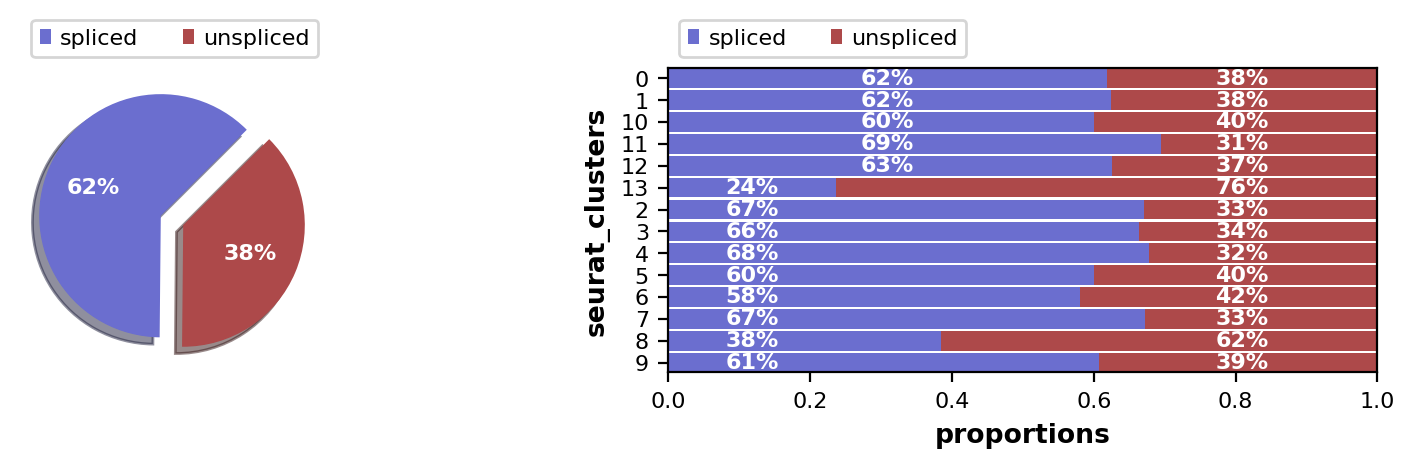

In [7]:
scv.pl.proportions(adata_velocity, groupby="seurat_clusters")

In [8]:
adata_velocity = run_scvelo(adata_velocity)

Filtered out 11888 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 8/128 cores)


  0%|          | 0/1705 [00:00<?, ?gene/s]

    finished (0:01:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:08) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph
    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


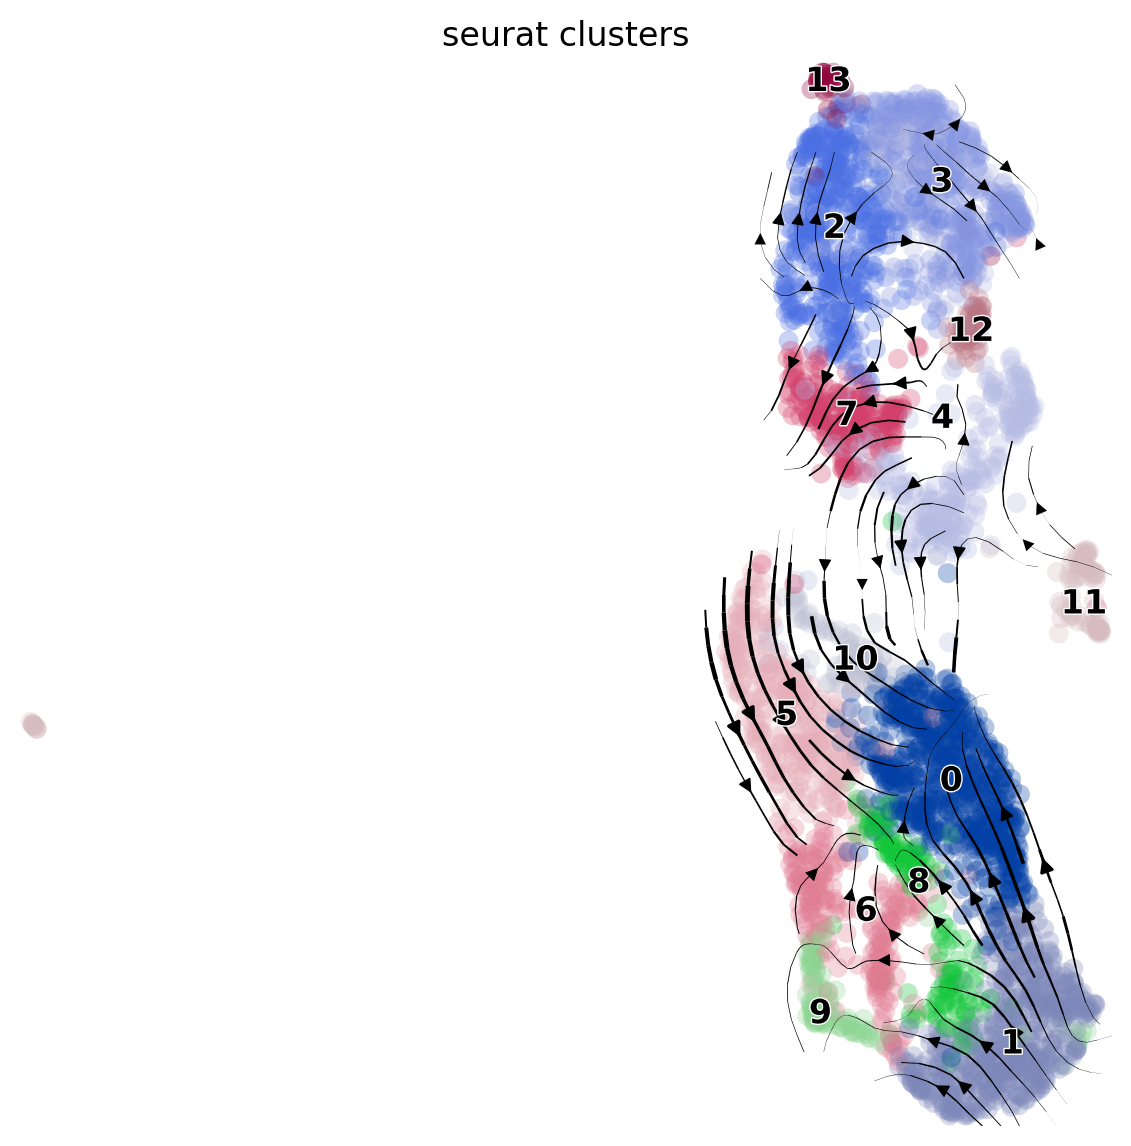

In [9]:
scv.pl.velocity_embedding_stream(adata_velocity, basis='umap', color=['seurat_clusters'])

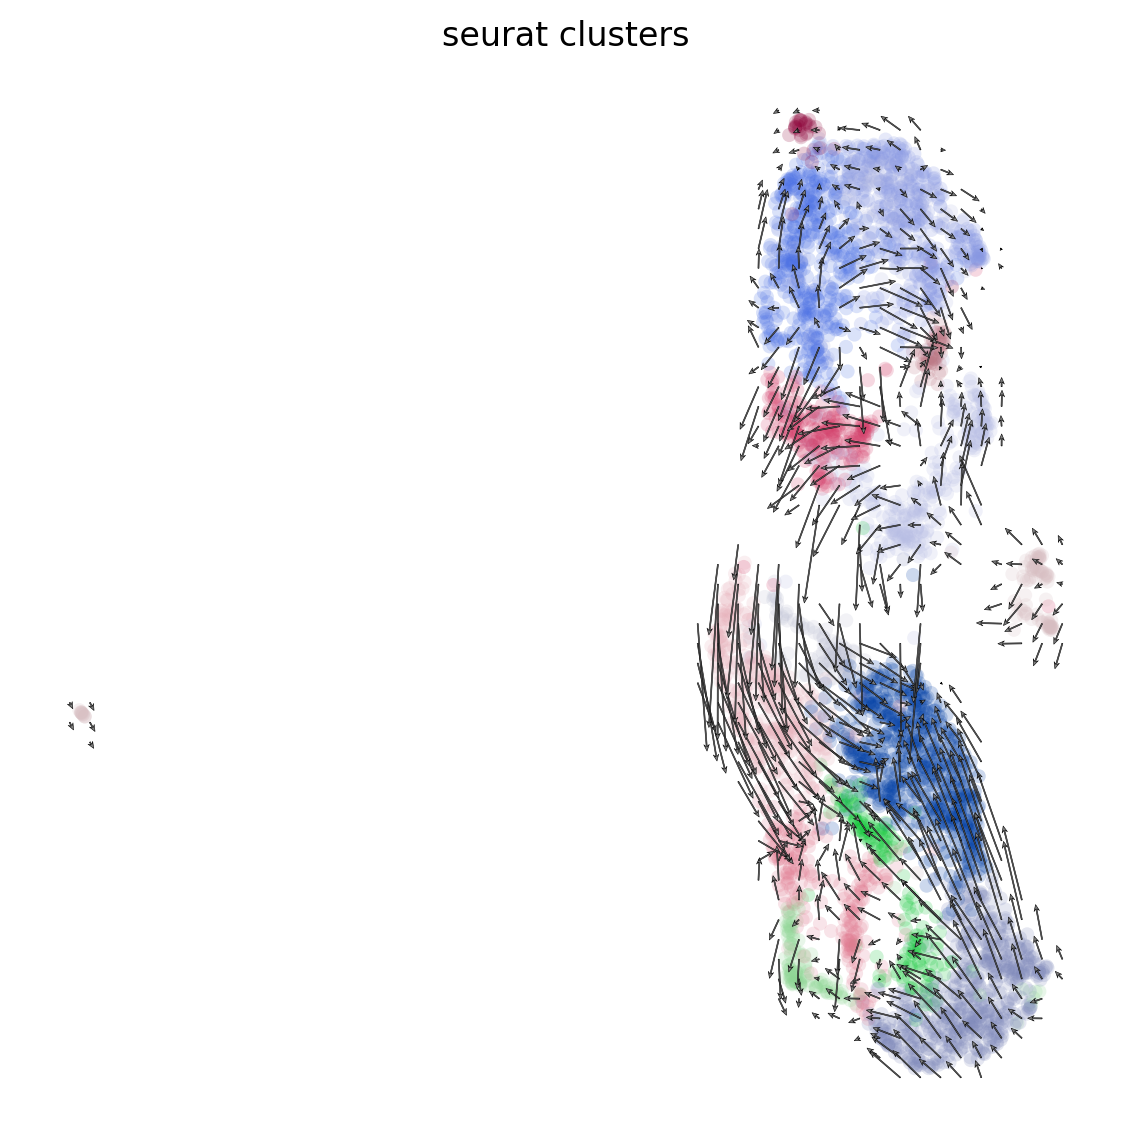

In [10]:
scv.pl.velocity_embedding_grid(adata_velocity, basis='umap', color='seurat_clusters', arrow_length=5)

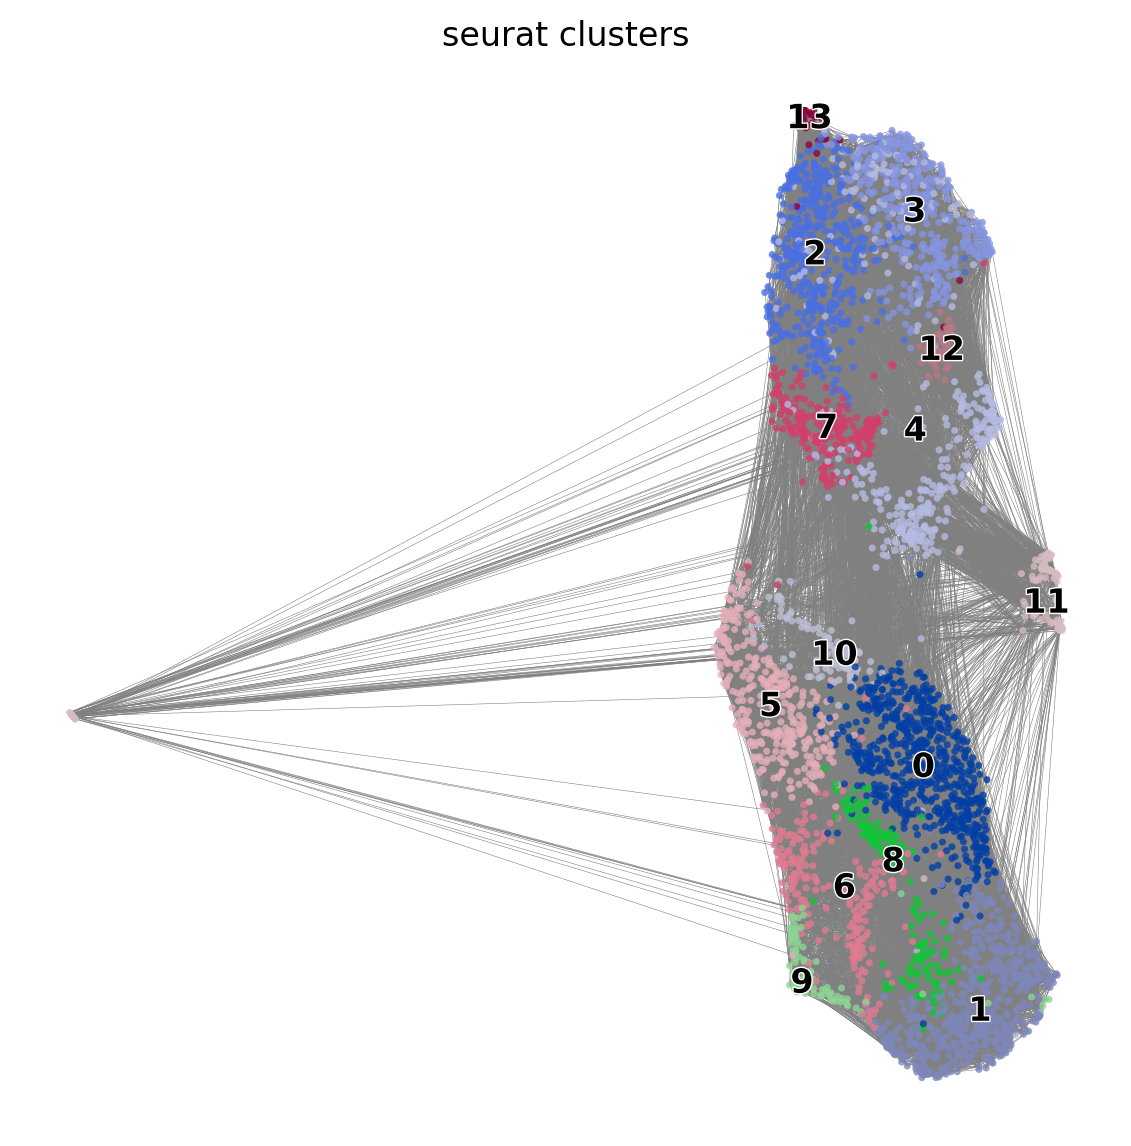

In [11]:
scv.pl.velocity_graph(adata_velocity, color='seurat_clusters')

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


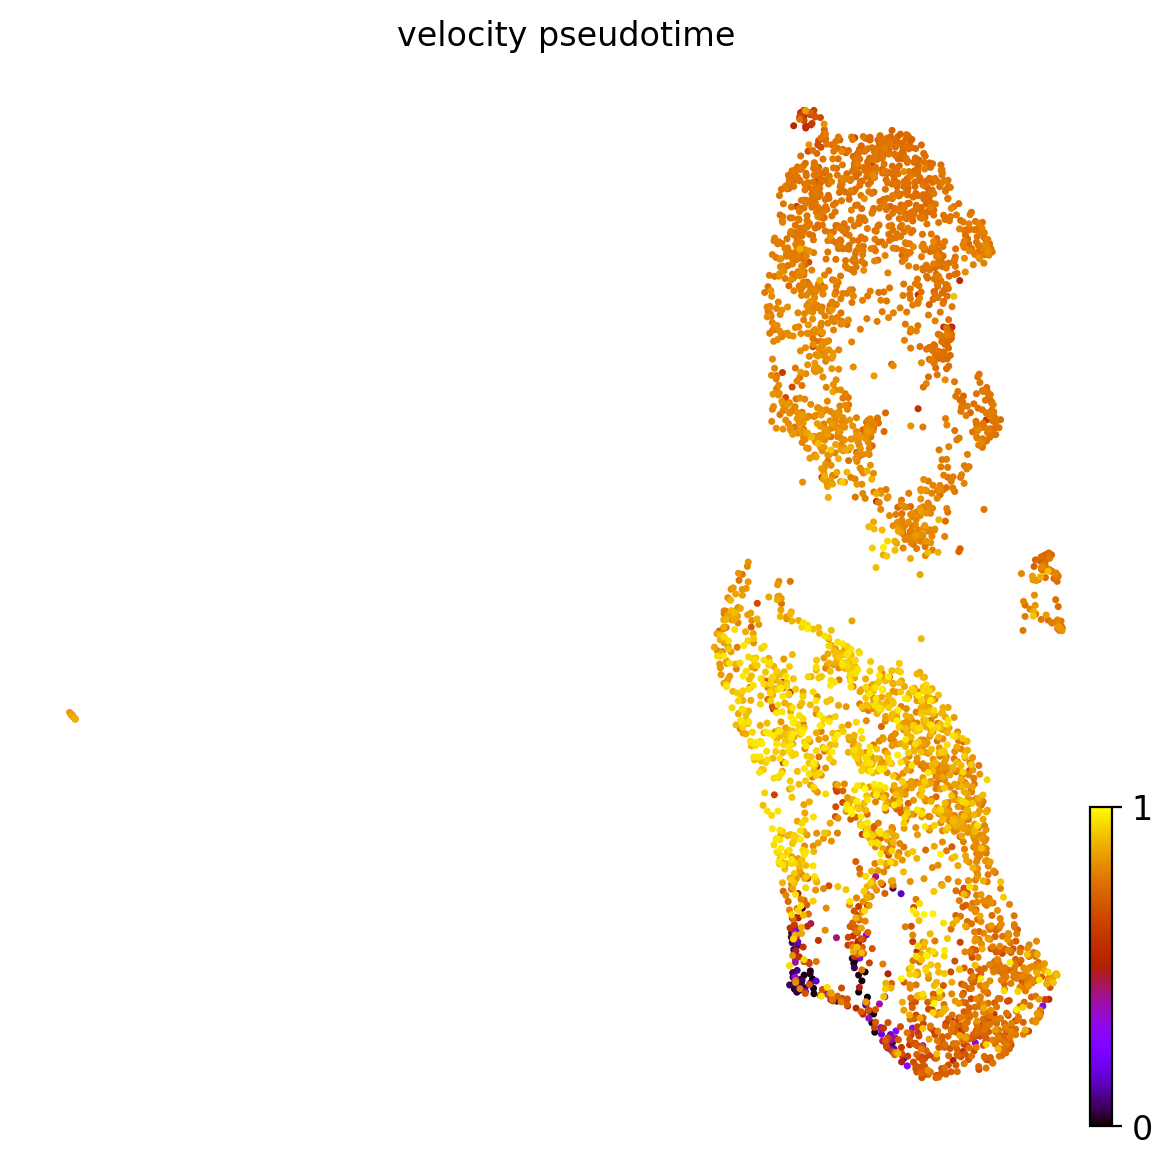

In [12]:
scv.tl.velocity_pseudotime(adata_velocity)
scv.pl.scatter(adata_velocity, color='velocity_pseudotime', cmap='gnuplot')

In [13]:
adata_velocity.uns['neighbors']['distances'] = adata_velocity.obsp['distances']
adata_velocity.uns['neighbors']['connectivities'] = adata_velocity.obsp['connectivities']

scv.tl.paga(adata_velocity, groups='seurat_clusters')
df = scv.get_df(adata_velocity, 'paga/transitions_confidence', precision=2, index=adata_velocity.obs.seurat_clusters.cat.categories, columns=adata_velocity.obs.seurat_clusters.cat.categories).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


,0,1,10,11,12,13,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.1,0,0,0,0,0,0,0,0,0,0,0,0.18,0
10,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11,0,0,0,0,0,0,0,0,0.17,0,0,0.2,0,0
12,0,0,0,0,0,0,0.069,0,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,0.11,0
2,0,0,0,0,0,0,0,0,0,0,0,0.13,0,0
3,0,0,0,0,0.036,0,0,0,0,0,0,0,0,0
4,0.14,0,0.18,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
df = scv.get_df(adata_velocity, 'paga/connectivities_tree', precision=2, index=adata_velocity.obs.seurat_clusters.cat.categories, columns=adata_velocity.obs.seurat_clusters.cat.categories).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

,0,1,10,11,12,13,2,3,4,5,6,7,8,9
0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,1,0,0,0,0
11,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,1,0,1,0,0,0,0,0,0
13,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0


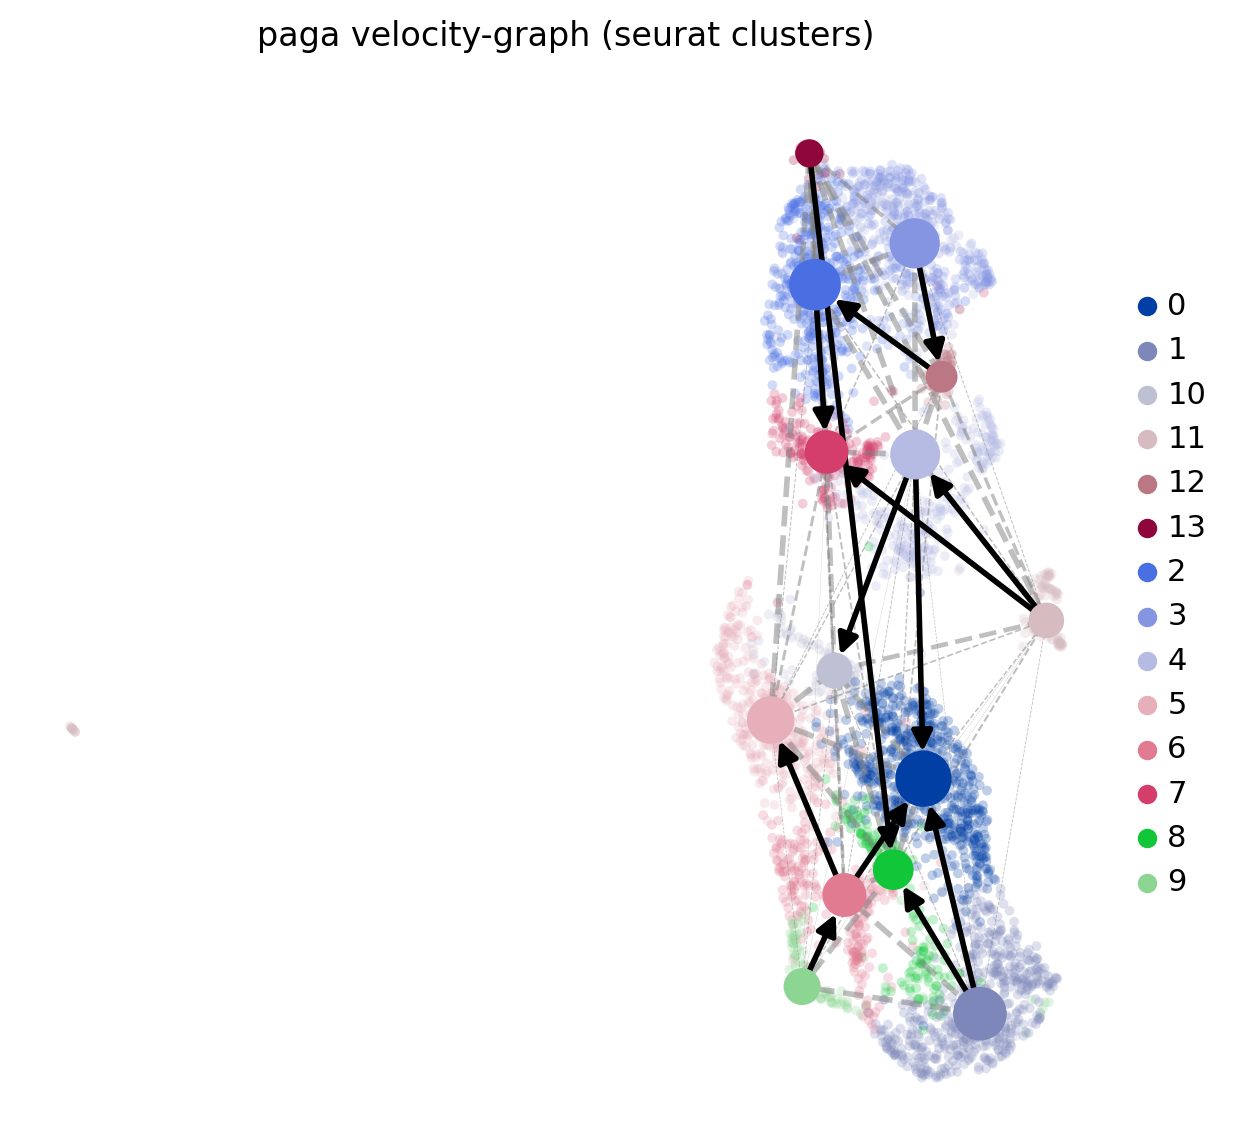

In [15]:
scv.pl.paga(adata_velocity, basis='umap', size=50, alpha=.25, min_edge_width=2, node_size_scale=1.5)

In [17]:
!jupyter nbconvert --to html 04_scvelo_full.ipynb --output-dir="../reports"

[NbConvertApp] Converting notebook 04_scvelo_full.ipynb to html
[NbConvertApp] Writing 705809 bytes to ../reports/04_scvelo_full.html
